In [136]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [137]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

In [138]:
# Diane's Ages
pdfout = fits.getdata('LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [139]:
#Transform gaia ra and dec to L and B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [164]:
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

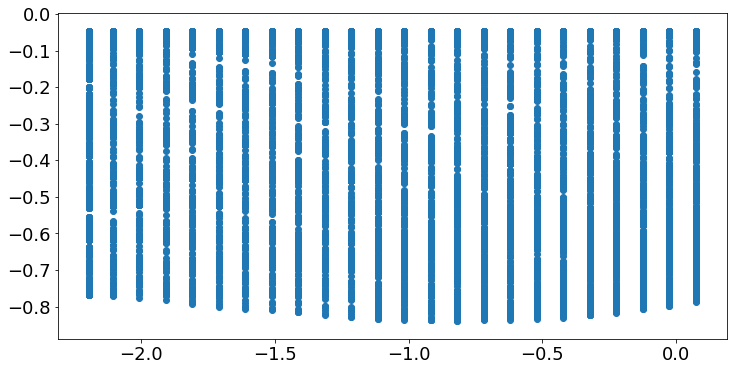

In [167]:
plt.scatter(parsec['MH'],np.log10(parsec['Xc']/sol_xm[0])-np.log10(parsec['Xn']/sol_xm[1]))

# PCA

In [191]:
data = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T
# data = np.array([parsec['logTe'],np.log10(parsec['Xc']/sol_xm[0])-np.log10(parsec['Xn']/sol_xm[1])
#                  ,parsec['C_O'],parsec['MH'],parsec['logg']]).T

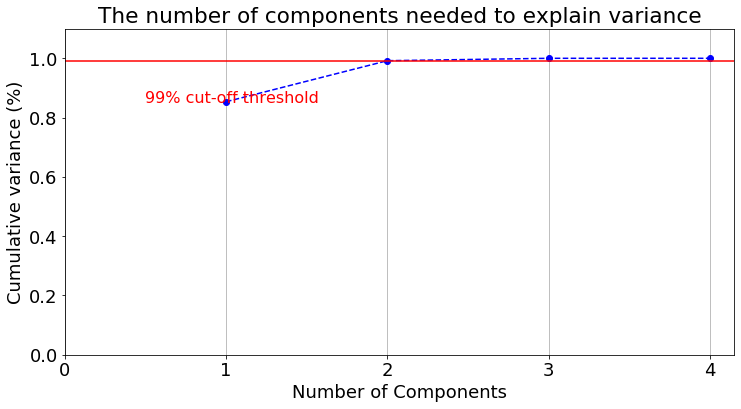

In [192]:
pca = PCA(n_components=4).fit(data)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [194]:
#transform data to new basis
new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables
x1 = new_data[:,0]
x2 = new_data[:,1]
x3 = new_data[:,2]
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3

#find all possible models
models = []
models_str = []
all_var_str = ['x1','x2','x3','x12','x13','x23','x1sq','x2sq','x3sq','x1cu','x2cu','x3cu']
all_var = [x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]
for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

In [195]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
resids = []
predict = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))

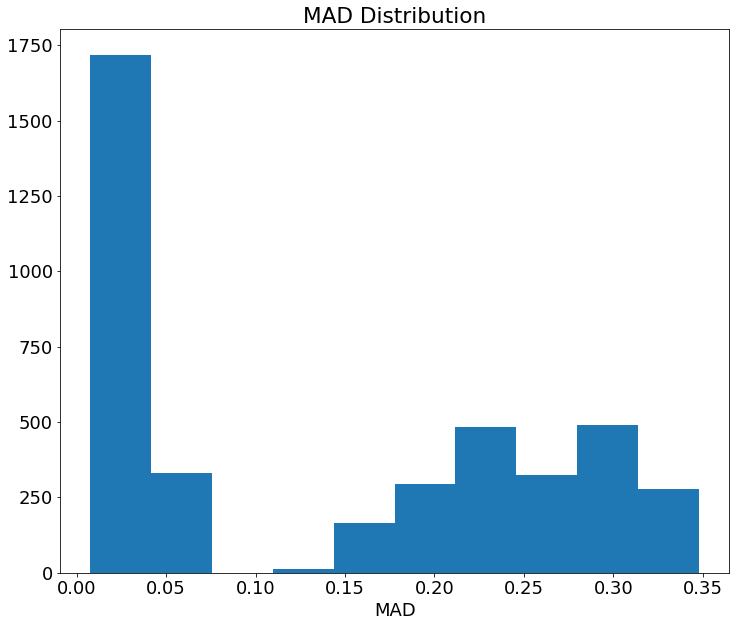

0.0076162422131051954
['x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu']
[ 9.38558878e+00  4.52603736e-02 -6.04406934e-02 -2.97535635e+00
  1.90507626e-02 -5.46867463e-02  1.09884832e-01 -5.87878556e-03
  2.50949914e-02  8.73273520e-01 -2.91548163e-05  2.28253331e-02]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.794e+06
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        12:17:20   Log-Likelihood:                 42646.
No. Observations:               14946   AIC:                        -8.527e+04
Df Residuals:                   14934   BIC:                        -8.518e+04
Df Model:                          11                                         
C

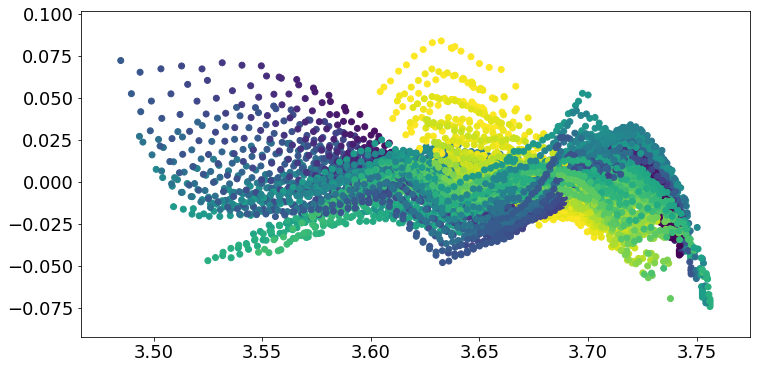

In [196]:
plt.figure(figsize=[12,10])
plt.hist(mads)
plt.title(r'MAD Distribution')
plt.xlabel(r'MAD')
# plt.savefig('MADdist.pdf',bbox_inches='tight')
plt.show()
print(np.asarray(mads)[np.asarray(mads).argmin()])
print(models_str[np.asarray(mads).argmin()])
print(all_params[np.asarray(mads).argmin()])
print(summaries[np.asarray(mads).argmin()])

plt.scatter(parsec['logTe'],resids[np.asarray(mads).argmin()],c=parsec['int_IMF'])

In [151]:
parsec.columns

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 4.613e+05
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        12:19:16   Log-Likelihood:                 31018.
No. Observations:               14946   AIC:                        -6.202e+04
Df Residuals:                   14936   BIC:                        -6.194e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4067      0.000   2.07e+04      0.0

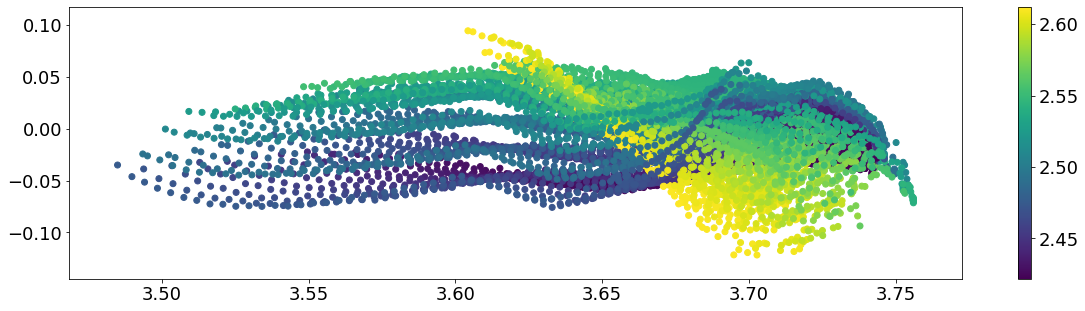

In [203]:
# parsimonious = np.array([x1, x2, x3, x12, x13, x23, x1sq, x2sq, x2cu]).T
parsimonious = np.array([x1, x2, x3, x12, x13, x23, x1sq, x2sq, x3sq, x1cu, x2cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))
print(afunc.mad(parsimonious_residual))

plt.figure(figsize=[20,5])
plt.scatter(parsec['logTe'],parsimonious_residual,c=parsec['int_IMF'])
plt.colorbar()

In [346]:
parsimonious = np.array([x1, x2, x3, x12, x13, x23, x1sq, x2sq, x3sq, x2cu]).T
parsimonious = np.array([x1, x2, x3, x12, x13, x23, x1sq, x2sq, x3sq, x2cu]).T
# parsimonious = np.array([x1, x2, x3, x12, x13, x23, x1sq, x2sq, x2cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.973e+06
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        21:44:40   Log-Likelihood:                 42644.
No. Observations:               14946   AIC:                        -8.527e+04
Df Residuals:                   14935   BIC:                        -8.518e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3856      0.000   4.14e+04      0.0

In [207]:
def find_ages(z1,z2,z3):
#     p = [9.39183782e+00,6.21217819e-02,4.29593576e-02,-2.95816612e+00,-1.43014007e-02,-6.47435954e-02,
#          -5.99196415e-02,-5.84656083e-03,1.71370300e-02,8.66227116e-01,-2.01258347e-02]
    p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
         1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
    return age
    
    
    
    #p = [9.41292724,0.05706436,-2.70513596]
    #return p[0]+p[1]*z1+p[2]*z2

In [210]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_N.append(sol_xm[1]*10**(r13['N_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_O.append(sol_xm[2]*10**(r13['O_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_S.append(sol_xm[5]*10**(r13['S_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H'][i]-r13['M_H'][i]))
    

factsCN = []

for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
factsCN.append(numerCN/denomCN)
    
factsCN = factsCN

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

_, _, stardist = afunc.LMCdisk_cart(r13['RA'],r13['DEC'])
corabsK = afunc.absmag(r13['K'],stardist)-r13['AK_TARG']

adat = np.array([np.log10(r13['TEFF']),corabsK,afunc.sal(r13['M_H'],metscorr),r13['LOGG']]).T

# print(adat)

zs = PCA(n_components=3).fit(data).transform(adat)

parage = find_ages(zs[:,0],zs[:,1],zs[:,2])

(array([4.00e+01, 1.61e+02, 1.96e+02, 5.52e+02, 1.09e+03, 5.17e+02,
        2.60e+01, 5.00e+00, 0.00e+00, 1.00e+00]),
 array([ 7.13094814,  7.76556671,  8.40018528,  9.03480384,  9.66942241,
        10.30404098, 10.93865954, 11.57327811, 12.20789668, 12.84251524,
        13.47713381]),
 <a list of 10 Patch objects>)

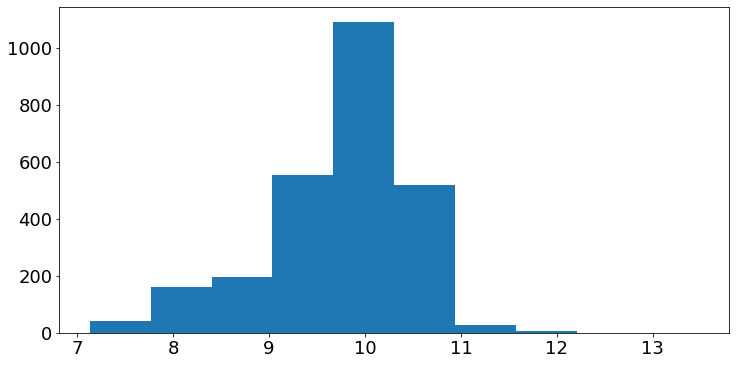

In [211]:
plt.hist(parage)

In [212]:
####################################
### Get Uncertainties: Add Noise ###
####################################

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

def sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR):
    '''
    Calculate noisy values for Salaris calculation with C and N.
    This does not take into account actually plugging in [M/H],
    for that use add_noise.
    
    Parameters:
        cfe: 1d array-like object of carbon abundances
        cfeERR: 1d array-like object of carbon abundance errors
        nfe: 1d array-like object of nitrogen abundances
        nfeERR: 1d array-like object of nitrogen abundance errors
        feh: 1d array-like object of iron abundances
        fehERR: 1d array-like object of iron abundance errors
        
    Return:
        noisy Salaris correction ffac
    '''
    
    sol_C = 0.28115244582676185 #solar carbon abundance
    sol_N = 0.06901474154376043 #solar nitrogen abundance
    
    # Calculate [C/M] and [N/M] with respective errors
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    # Calculate X fractions for C and N with respective errors
    x_C = sol_C*10**(cm)
    x_N = sol_N*10**(nm)
    
    x_CERR = 10**(cm)*np.log(10)*CMERR
    x_NERR = 10**(nm)*np.log(10)*NMERR
    
    # Calcuate f factor in Salaris correction with respective errors
    ffac = (x_C+x_N)/(sol_C+sol_N) #factor from Salaris correction
    ffacERR = np.sqrt((x_CERR)**2+(x_NERR)**2)/(sol_C+sol_N)
    
    # Add noise to calculated f factor
    ffacnoise = np.random.uniform(-np.absolute(0.434*(ffacERR/ffac)),np.absolute(0.434*(ffacERR/ffac))) 
    
    return ffac + ffacnoise

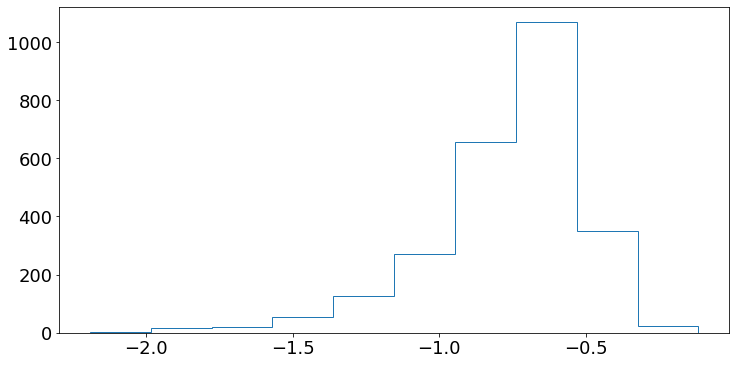

In [342]:
plt.hist(r13['FE_H'],histtype='step')
plt.show()

In [469]:
###################################
### Calculate Age Distributions ###
###################################

age_dist = []

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
#         if feh <= halo_cutoff:
#             dist_new = add_noise(dist,1.0,distribution='uniform')
#             absK_new = afunc.absmag(ks_new,dist_new) - ak
        
#         else:
#             absK_new = afunc.absmag(ks_new,dist) - ak
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))
        
#     noise_ages.append(find_ages(zs[0],zs[1],zs[2]))
    

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))#noise_ages)
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in range(len(age_dist)):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

In [347]:
################################
### Calculate  Uncertainties ###
################################

noisy = []
halo_cutoff = -1.

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        if feh <= halo_cutoff:
            dist_new = add_noise(dist,1.0,distribution='uniform')
            absK_new = afunc.absmag(ks_new,dist_new) - ak
        
        else:
            absK_new = afunc.absmag(ks_new,dist) - ak
            
#         absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))
        
#     noise_ages.append(find_ages(zs[0],zs[1],zs[2]))
    

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))#noise_ages)
    
    noisy.append(noise_ages)
    
devs1 = []
for k in range(len(noisy)):
    devs1.append(afunc.mad(noisy[k]))

In [352]:
################################
### Calculate  Uncertainties ###
################################

noisy = []
halo_cutoff = -1.

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        if feh <= halo_cutoff:
            dist_new = add_noise(dist,2.5,distribution='uniform')
            absK_new = afunc.absmag(ks_new,dist_new) - ak
        
        else:
            absK_new = afunc.absmag(ks_new,dist) - ak
            
#         absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))
        
#     noise_ages.append(find_ages(zs[0],zs[1],zs[2]))
    

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))#noise_ages)
    
    noisy.append(noise_ages)
    
devs2_5 = []
for k in range(len(noisy)):
    devs2_5.append(afunc.mad(noisy[k]))

In [348]:
################################
### Calculate  Uncertainties ###
################################

noisy = []
halo_cutoff = -1.

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        if feh <= halo_cutoff:
            dist_new = add_noise(dist,5,distribution='uniform')
            absK_new = afunc.absmag(ks_new,dist_new) - ak
        
        else:
            absK_new = afunc.absmag(ks_new,dist) - ak
            
#         absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))
        
#     noise_ages.append(find_ages(zs[0],zs[1],zs[2]))
    

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))#noise_ages)
    
    noisy.append(noise_ages)
    
devs5 = []
for k in range(len(noisy)):
    devs5.append(afunc.mad(noisy[k]))

In [349]:
################################
### Calculate  Uncertainties ###
################################

noisy = []
halo_cutoff = -1.

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        if feh <= halo_cutoff:
            dist_new = add_noise(dist,7.5,distribution='uniform')
            absK_new = afunc.absmag(ks_new,dist_new) - ak
        
        else:
            absK_new = afunc.absmag(ks_new,dist) - ak
            
#         absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))
        
#     noise_ages.append(find_ages(zs[0],zs[1],zs[2]))
    

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))#noise_ages)
    
    noisy.append(noise_ages)
    
devs7_5 = []
for k in range(len(noisy)):
    devs7_5.append(afunc.mad(noisy[k]))

In [350]:
################################
### Calculate  Uncertainties ###
################################

noisy = []
halo_cutoff = -1.

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        if feh <= halo_cutoff:
            dist_new = add_noise(dist,10,distribution='uniform')
            absK_new = afunc.absmag(ks_new,dist_new) - ak
        
        else:
            absK_new = afunc.absmag(ks_new,dist) - ak
            
#         absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))
        
#     noise_ages.append(find_ages(zs[0],zs[1],zs[2]))
    

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))#noise_ages)
    
    noisy.append(noise_ages)
    
devs10 = []
for k in range(len(noisy)):
    devs10.append(afunc.mad(noisy[k]))

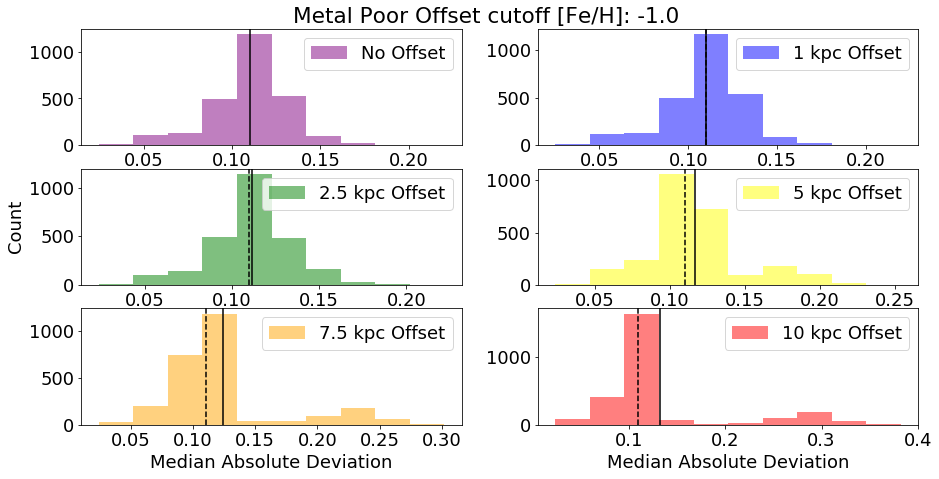

In [465]:
###############################
### Compare Different Offsets ###
###############################

plt.figure(figsize=[15,15])
plt.suptitle(r'Metal Poor Offset cutoff [Fe/H]: -1.0',y=0.9)

plt.subplot(621)
plt.hist(devs_no_halo,label='No Offset',alpha=0.5,color='purple')#,histtype='step')
plt.axvline(np.mean(devs_no_halo),c='k',ls='-')
plt.legend()

plt.subplot(622)
plt.hist(devs1,label='1 kpc Offset',alpha=0.5,color='blue')#,histtype='step')
plt.axvline(np.mean(devs_no_halo),c='k',ls='--')
plt.axvline(np.mean(devs1),c='k',ls='-')
plt.legend()

plt.subplot(623)
plt.hist(devs2_5,label='2.5 kpc Offset',alpha=0.5,color='green')#,histtype='step')
plt.axvline(np.mean(devs_no_halo),c='k',ls='--')
plt.axvline(np.mean(devs2_5),c='k',ls='-')
plt.ylabel('Count')
plt.legend()

plt.subplot(624)
plt.hist(devs5,label='5 kpc Offset',alpha=0.5,color='yellow')#,histtype='step')
plt.axvline(np.mean(devs_no_halo),c='k',ls='--')
plt.axvline(np.mean(devs5),c='k',ls='-')
plt.legend()

plt.subplot(625)
plt.hist(devs7_5,label='7.5 kpc Offset',alpha=0.5,color='orange')#,histtype='step')
plt.axvline(np.mean(devs_no_halo),c='k',ls='--')
plt.axvline(np.mean(devs7_5),c='k',ls='-')
plt.xlabel(r'Median Absolute Deviation')
plt.legend()

plt.subplot(626)
plt.hist(devs10,label='10 kpc Offset',alpha=0.5,color='red')#,histtype='step')
plt.axvline(np.mean(devs_no_halo),c='k',ls='--')
plt.axvline(np.mean(devs10),c='k',ls='-')
plt.xlabel(r'Median Absolute Deviation')
plt.legend()

plt.savefig('PCAOLS_ErrorDistribution_MP_dist.png',bbox_inches='')

plt.show()

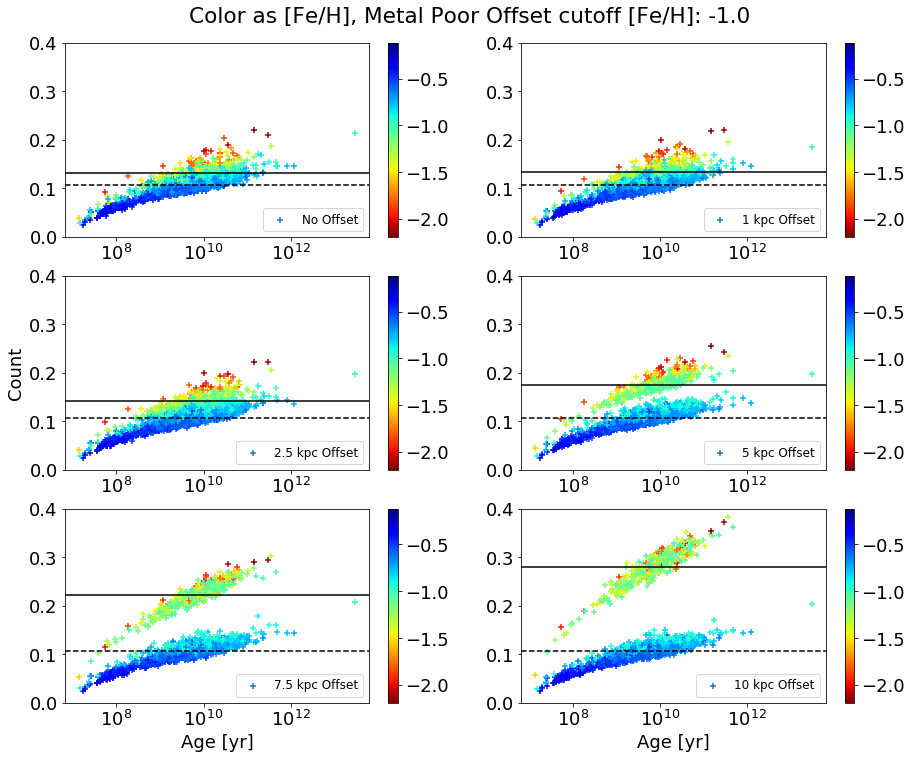

In [466]:
mpOffset = np.where(r13['FE_H']<=-1.0)
notOffset = np.where(r13['FE_H']>-1.0)

plt.figure(figsize=[15,25])
plt.suptitle(r'Color as [Fe/H], Metal Poor Offset cutoff [Fe/H]: -1.0',y=0.9)

plt.subplot(621)
plt.scatter(10**np.asarray(parage),np.asarray(devs_no_halo),marker='+',c=r13['FE_H'],cmap='jet_r',
            label='No Offset')
plt.axhline(np.mean(np.asarray(devs_no_halo)[notOffset]),c='k',ls='--')
plt.axhline(np.mean(np.asarray(devs_no_halo)[mpOffset]),c='k',ls='-')

plt.xscale('log')
plt.legend(loc='lower right',fontsize='12')
plt.ylim(0,0.4)
plt.colorbar()

plt.subplot(622)
plt.scatter(10**np.asarray(parage),np.asarray(devs1),marker='+',c=r13['FE_H'],cmap='jet_r',
            label='1 kpc Offset')
plt.axhline(np.mean(np.asarray(devs_no_halo)[notOffset]),c='k',ls='--')
plt.axhline(np.mean(np.asarray(devs1)[mpOffset]),c='k',ls='-')
plt.xscale('log')
plt.legend(loc='lower right',fontsize='12')
plt.colorbar()
plt.ylim(0,0.4)

plt.subplot(623)
plt.scatter(10**np.asarray(parage),np.asarray(devs2_5),marker='+',c=r13['FE_H'],cmap='jet_r',
            label='2.5 kpc Offset')
plt.axhline(np.mean(np.asarray(devs_no_halo)[notOffset]),c='k',ls='--')
plt.axhline(np.mean(np.asarray(devs2_5)[mpOffset]),c='k',ls='-')
plt.ylabel('Count')
plt.xscale('log')
plt.legend(loc='lower right',fontsize='12')
plt.ylim(0,0.4)
plt.colorbar()

plt.subplot(624)
plt.scatter(10**np.asarray(parage),np.asarray(devs5),marker='+',c=r13['FE_H'],cmap='jet_r',
            label='5 kpc Offset')
plt.axhline(np.mean(np.asarray(devs_no_halo)[notOffset]),c='k',ls='--')
plt.axhline(np.mean(np.asarray(devs5)[mpOffset]),c='k',ls='-')
plt.xscale('log')
plt.legend(loc='lower right',fontsize='12')
plt.colorbar()
plt.ylim(0,0.4)

plt.subplot(625)
plt.scatter(10**np.asarray(parage),np.asarray(devs7_5),marker='+',c=r13['FE_H'],cmap='jet_r',
            label='7.5 kpc Offset')
plt.axhline(np.mean(np.asarray(devs_no_halo)[notOffset]),c='k',ls='--')
plt.axhline(np.mean(np.asarray(devs7_5)[mpOffset]),c='k',ls='-')
plt.xlabel(r'Age [yr]')
plt.xscale('log')
plt.legend(loc='lower right',fontsize='12')
plt.ylim(0,0.4)
plt.colorbar()

plt.subplot(626)
plt.scatter(10**np.asarray(parage),np.asarray(devs10),marker='+',c=r13['FE_H'],cmap='jet_r',
            label='10 kpc Offset')
plt.axhline(np.mean(np.asarray(devs_no_halo)[notOffset]),c='k',ls='--')
plt.axhline(np.mean(np.asarray(devs10)[mpOffset]),c='k',ls='-')
plt.xlabel(r'Age [yr]')
plt.xscale('log')
plt.legend(loc='lower right',fontsize='12')
plt.colorbar()
plt.ylim(0,0.4)

plt.savefig('PCAOLS_Error_MP_dist.png',bbox_inches='')
plt.show()

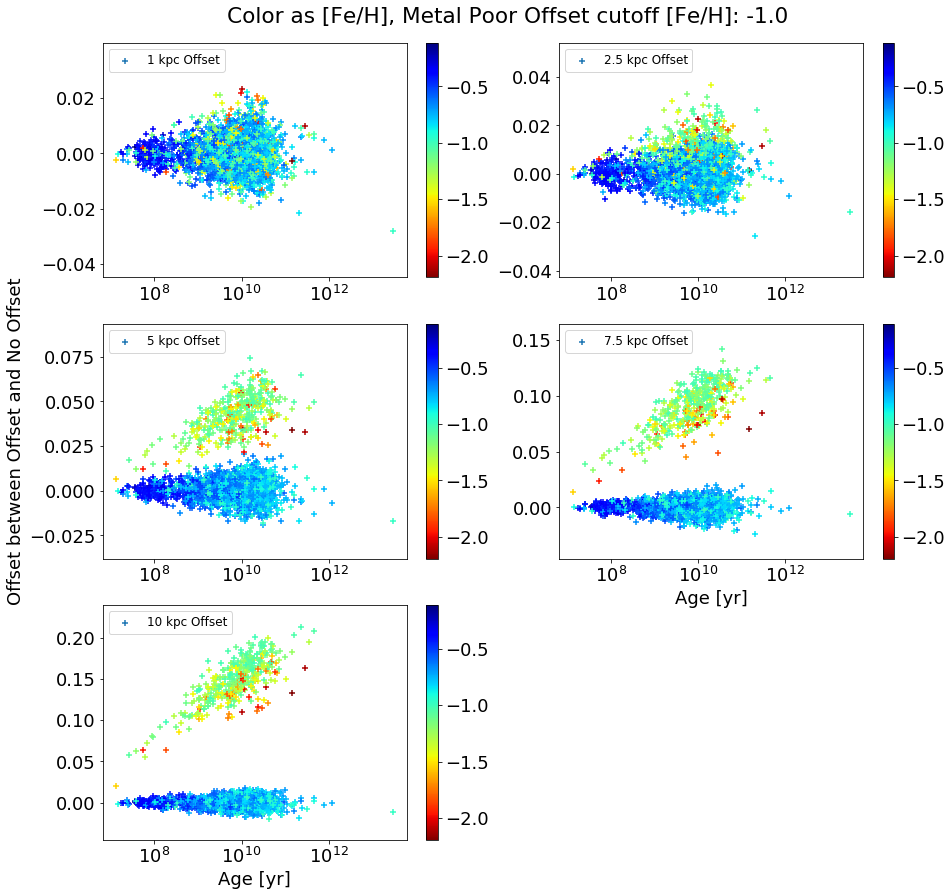

In [467]:
mpOffset = np.where(r13['FE_H']<=-1.0)
notOffset = np.where(r13['FE_H']>-1.0)

plt.figure(figsize=[15,25])
plt.suptitle(r'Color as [Fe/H], Metal Poor Offset cutoff [Fe/H]: -1.0',y=0.9)

plt.subplot(521)
plt.scatter(10**np.asarray(parage),np.asarray(devs1)-np.asarray(devs_no_halo),marker='+',c=r13['FE_H'],
            cmap='jet_r',label='1 kpc Offset')
plt.xscale('log')
plt.legend(loc='upper left',fontsize='12')
plt.colorbar()
# plt.ylim(0,0.4)

plt.subplot(522)
plt.scatter(10**np.asarray(parage),np.asarray(devs2_5)-np.asarray(devs_no_halo),marker='+',c=r13['FE_H'],
            cmap='jet_r',label='2.5 kpc Offset')
plt.xscale('log')
plt.legend(loc='upper left',fontsize='12')
# plt.ylim(0,0.4)
plt.colorbar()

plt.subplot(523)
plt.scatter(10**np.asarray(parage),np.asarray(devs5)-np.asarray(devs_no_halo),marker='+',c=r13['FE_H'],
            cmap='jet_r',label='5 kpc Offset')
plt.xscale('log')
plt.legend(loc='upper left',fontsize='12')
plt.ylabel(r'Offset between Offset and No Offset')
plt.colorbar()
# plt.ylim(0,0.4)

plt.subplot(524)
plt.scatter(10**np.asarray(parage),np.asarray(devs7_5)-np.asarray(devs_no_halo),marker='+',c=r13['FE_H'],
            cmap='jet_r',label='7.5 kpc Offset')
plt.xlabel(r'Age [yr]')
plt.xscale('log')
plt.legend(loc='upper left',fontsize='12')
# plt.ylim(0,0.4)
plt.colorbar()

plt.subplot(525)
plt.scatter(10**np.asarray(parage),np.asarray(devs10)-np.asarray(devs_no_halo),marker='+',c=r13['FE_H'],
            cmap='jet_r',label='10 kpc Offset')
plt.xlabel(r'Age [yr]')
plt.xscale('log')
plt.legend(loc='upper left',fontsize='12')
plt.colorbar()
# plt.ylim(0,0.4)

plt.savefig('PCAOLS_starbystar_ErrorOffset.png',bbox_inches='tight')

plt.show()

In [274]:
### blue loop cut
bloop = np.where((r13['TEFF']>=4100)&(r13['H']<=13.0)&((r13['J']-r13['K'])<=0.95))

bloop_cut = []
for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)

In [317]:
np.where(np.isfinite(10**np.asarray(parage))==False)

(array([], dtype=int64),)

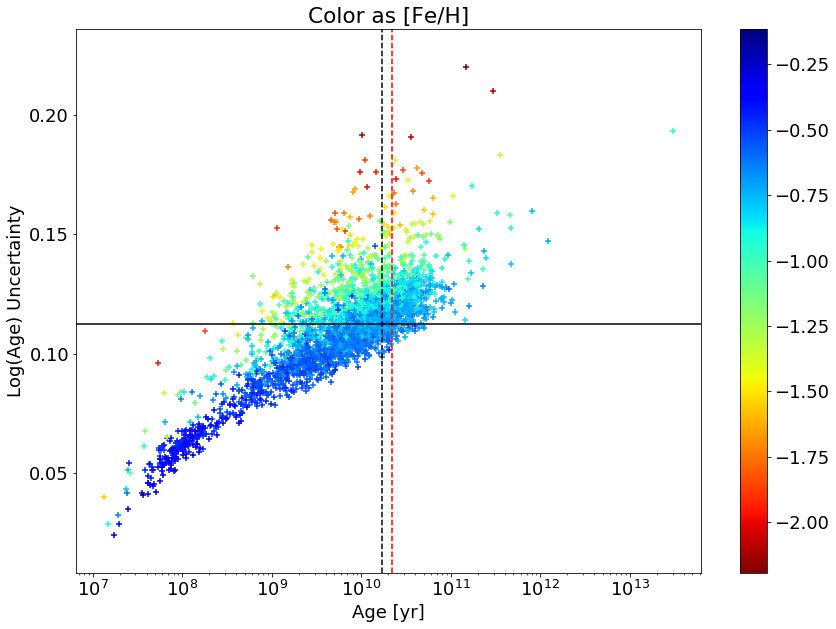

In [341]:
### Error Plot

# mod_devs = np.asarray(devs)[np.where(np.asarray(devs)<1.16)]

plt.figure(figsize=[14,10])

plt.scatter(10**np.asarray(parage),np.asarray(devs),marker='+',c=r13['FE_H'],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.median(devs)),c='k',ls='--')
plt.axvline(10**(np.log10(ageU)+np.max(devs)),c='r',ls='--')
plt.axhline(np.median(devs),c='k')
plt.xscale('log')
# plt.xlim(left=10**7)
# plt.ylim(top=2.0)
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty')
plt.title(r'Color as [Fe/H]')
# plt.savefig('PCAOLS_uncert2.pdf',bbox_inches='tight')
plt.show()

In [334]:
len(np.squeeze(np.where(parage>np.log10(ageU)+np.max(devs))))/len(parage)

0.1920401854714065

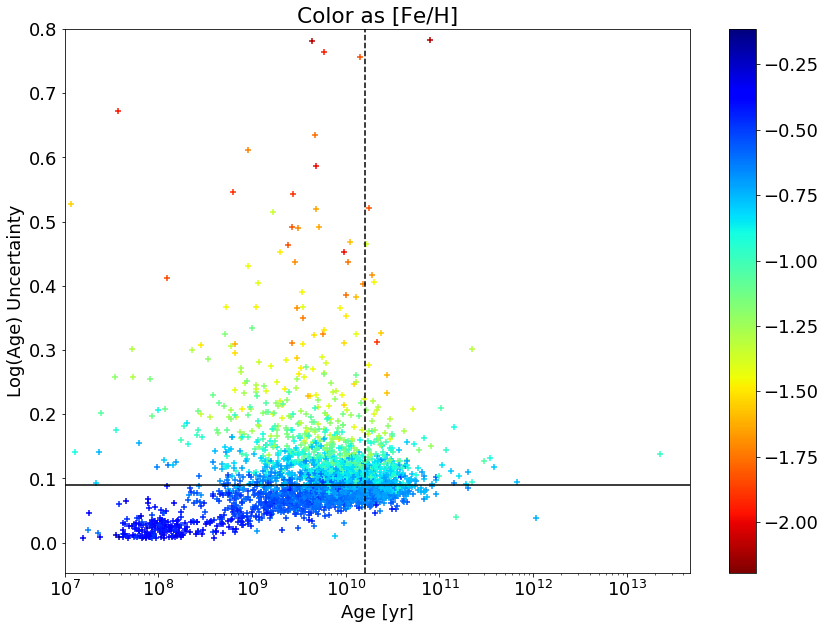

In [115]:
### Error Plot

mod_devs = np.asarray(devs)[np.where(np.asarray(devs)<1.16)]

plt.figure(figsize=[14,10])
plt.scatter(10**np.asarray(parage),devs,marker='+',c=r13['FE_H'],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.median(devs)),c='k',ls='--')
# plt.axvline(10**(np.log10(ageU)+np.max(mod_devs)),c='r',ls='--')
plt.axhline(np.median(devs),c='k')
plt.xscale('log')
plt.xlim(left=10**7)
plt.ylim(top=0.8)
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty')
plt.title(r'Color as [Fe/H]')
plt.savefig('PCAOLS_uncert2.pdf',bbox_inches='tight')
plt.show()

In [116]:
################################
### Calculate  Uncertainties ###
################################

no_halo_devs = []
halo_cutoff = -1.53

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
#         if feh <= halo_cutoff:
#             dist_new = add_noise(dist,1.0,distribution='uniform')
#             absK_new = afunc.absmag(ks_new,dist_new) - ak
        
#         else:
#             absK_new = afunc.absmag(ks_new,dist) - ak
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new = np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]).T
        
        noise_ages.append(find_ages(new[0],new[1],new[2]))
    
    no_halo_devs.append(afunc.mad(noise_ages))

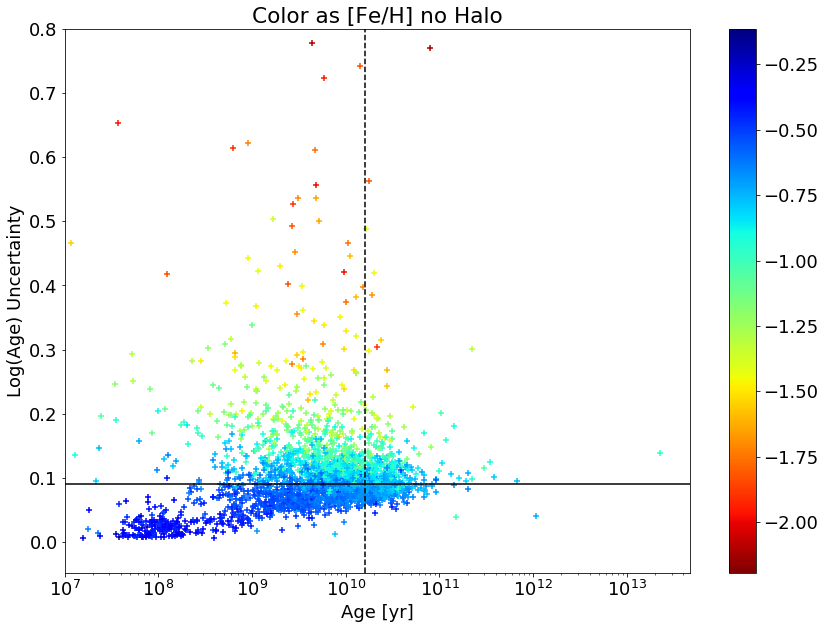

In [118]:

mod_no_halo_devs = np.asarray(no_halo_devs)[np.where(np.asarray(no_halo_devs)<1.16)]

plt.figure(figsize=[14,10])
plt.scatter(10**np.asarray(parage),no_halo_devs,marker='+',c=r13['FE_H'],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.median(no_halo_devs)),c='k',ls='--')
# plt.axvline(10**(np.log10(ageU)+np.max(mod_no_halo_devs)),c='r',ls='--')
plt.axhline(np.median(no_halo_devs),c='k')
plt.xscale('log')
plt.xlim(left=10**7)
plt.ylim(top=0.8)
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty')
plt.title(r'Color as [Fe/H] no Halo')
# plt.savefig('PCAOLS_uncert2.pdf',bbox_inches='tight')
plt.show()

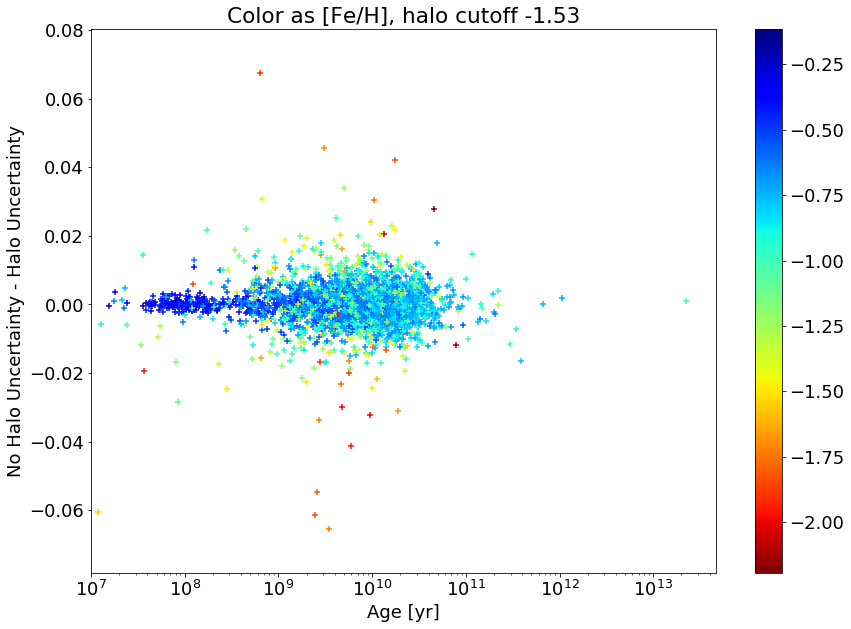

In [123]:
mod_no_halo_devs = np.asarray(no_halo_devs)[np.where(np.asarray(no_halo_devs)<1.16)]

plt.figure(figsize=[14,10])
plt.scatter(10**np.asarray(parage),np.asarray(no_halo_devs)-np.asarray(devs),marker='+',c=r13['FE_H'],
            cmap='jet_r')
plt.colorbar()
# plt.axvline(10**(np.log10(ageU)+np.median(no_halo_devs)),c='k',ls='--')
# plt.axvline(10**(np.log10(ageU)+np.max(mod_no_halo_devs)),c='r',ls='--')
# plt.axhline(np.median(no_halo_devs),c='k')
plt.xscale('log')
plt.xlim(left=10**7)
# plt.ylim(top=0.8)
plt.xlabel(r'Age [yr]')
plt.ylabel(r'No Halo Uncertainty - Halo Uncertainty')
plt.title(r'Color as [Fe/H], halo cutoff -1.53')
plt.savefig('halo_nohalo_uncert.png',bbox_inches='tight')
plt.show()

In [38]:
print('10.13 + median devs: ',len(np.squeeze(np.where(parage>=10.13+np.median(devs))))/len(parage)*100)
print('10.13 + max mod_devs: ',len(np.squeeze(np.where(parage>=10.13+np.max(mod_devs))))/len(parage)*100)

10.13 + median devs:  24.53632148377125
10.13 + max mod_devs:  0.8500772797527048


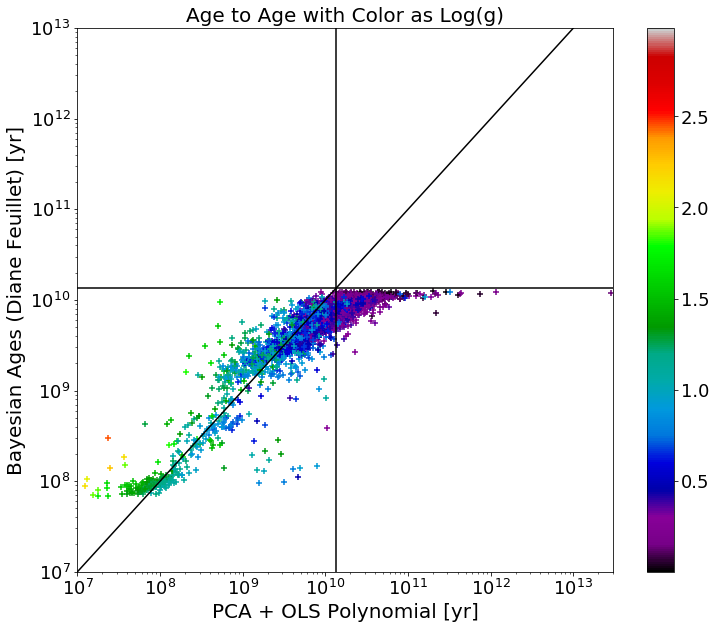

In [44]:
########################
### compare to Diane ###
########################

plt.figure(figsize=[12,10])
plt.scatter(10**parage[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**13)
plt.xlim(left=10**7)

# plt.scatter(10**12,10**7.5,c='k',marker='+')
# plt.errorbar(10**12,10**7.5,xerr=np.sqrt((10**12)**2*(np.median(devs))**2),c='k',capsize=2,marker='+')

plt.axvline(10**10.13,c='k')
plt.axhline(10**10.13,c='k')
# plt.axvline(10**(np.log10(ageU)+np.max(mod_devs)),c='r',linestyle='--')
# plt.axvline(10**(np.log10(ageU)+np.median(mod_devs)),c='r',linestyle='--')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'PCA + OLS Polynomial [yr]',fontsize=20)
plt.ylabel(r'Bayesian Ages (Diane Feuillet) [yr]',fontsize=20)
plt.title(r'Age to Age with Color as Log(g)',fontsize=20)
plt.savefig('age2age_PCA_OLS2.pdf',bbox_inches='tight')
plt.show()

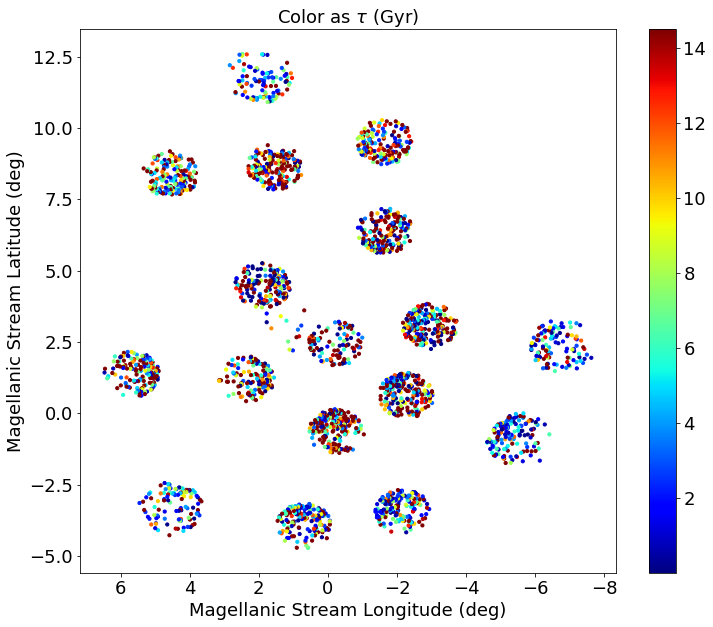

In [50]:
plt.figure(figsize=[12,10])

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0
plt.scatter(ms_lg-360,ms_bg,c=(10**parage)/10**9,cmap='jet',vmax=14.5,s=10)
plt.gca().invert_xaxis()
plt.colorbar()
plt.title(r'Color as $\tau$ (Gyr)',fontsize=18)
plt.ylabel(r'Magellanic Stream Latitude (deg)',fontsize=18)
plt.xlabel(r'Magellanic Stream Longitude (deg)',fontsize=18)
plt.savefig('agemap.jpg',bbox_inches='tight')
plt.show()

In [52]:
# r12 = fits.getdata('allStar-r12-l33beta.mc.fits.gz') 
# _,d_r13_ind,d_r12_ind = np.intersect1d(r13['APOGEE_ID'],beta['APOGEE_ID'],
#                                         return_indices=True)

# r12 = r12[d_r12_ind]
# r13_d = r13[d_r13_ind]

# r12dist = []
# for i in range(len(r12)):
#     r12dist.append(r12['DISO'][i][1])
    
# r12dist = np.asarray(r12dist)

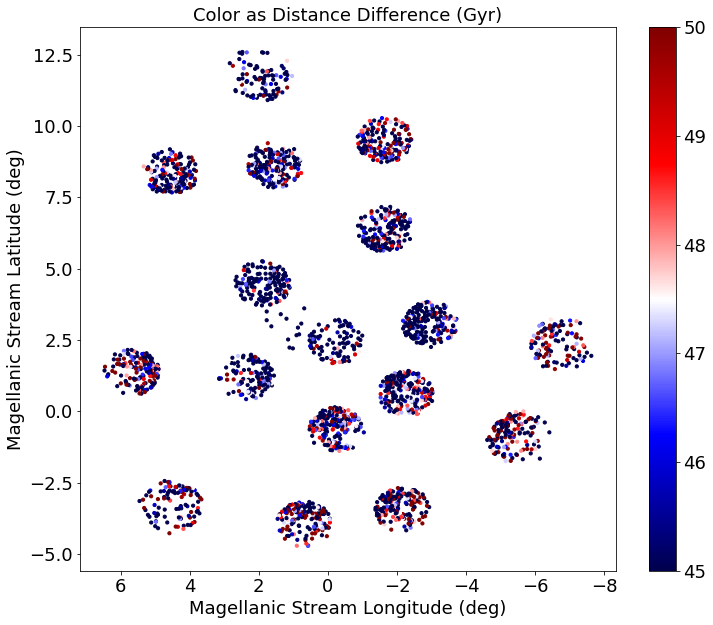

In [108]:
r13wd = fits.getdata('mc_rgbmembers.r13-l33-58932beta.fits.gz') 
_,d_r13_ind,d_r13wd_ind = np.intersect1d(r13['APOGEE_ID'],r13wd['APOGEE_ID'],
                                        return_indices=True)

r13_old = r13[d_r13_ind]
r13wd = r13wd[d_r13wd_ind]

r13dist = []
for i in range(len(r13wd)):
    r13dist.append(r13wd['DISO'][i][1])
    
c_icrs = SkyCoord(ra=r13_old['RA']*u.degree, dec=r13_old['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg13wd,ms_bg13wd = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree
    
plt.figure(figsize=[12,10])

for i in range(len(ms_lg13wd)):
    if ms_lg13wd[i]-360<-180:
        ms_lg13wd[i] += 360.0
        
plt.scatter(ms_lg13wd-360,ms_bg13wd,c=np.asarray(r13dist)/1000.,cmap='seismic',vmax=50,vmin=45,s=10)
plt.gca().invert_xaxis()
plt.colorbar()
plt.title(r'Color as Distance Difference (Gyr)',fontsize=18)
plt.ylabel(r'Magellanic Stream Latitude (deg)',fontsize=18)
plt.xlabel(r'Magellanic Stream Longitude (deg)',fontsize=18)
# plt.savefig('agemap.jpg',bbox_inches='tight')
plt.show()

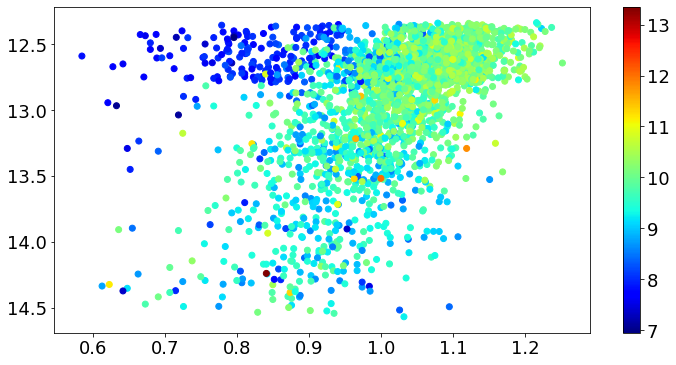

In [127]:
plt.figure(figsize=[12,10])
plt.subplot(121)
plt.scatter(r13_old['J']-r13_old['K'],r13_old['H'],c=parage[d_r13_ind],cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()